In [78]:
# Imports for the project
import random
import matplotlib.pyplot as plt
import math
from math import comb
from collections import Counter

# ADA511 Course Project: Yahtzee
By: Ole A. Solem & Henrik Vallestad

* We have limited our project to only the **first part of Yahtzee**, where the goal is to get as many of each kind **[1, 2, 3, 4, 5, 6]** and then sum them.
* If the **sum** of [1s, 2s, 3s, 4s, 5s, 6s] is 63, the agent gets a **bonus of 50 points**. 
* Also if the agent gets 5 of a kind, **Yahtzee**, it gets 50 points (which **do not** count on the 63-bonus, but it adds to the total score)
* We run **400 000** games for each scenario, this will give us enough data to accuratly compare them.

We have programmed four different scenarios:

1. **Greedy Algorithm**: Always keeps the highest value.
2. **Strategy with Three of a Kind**: Incorporates a strategy where we try to always get three of a kind and use probability inference to decide whether to keep multiple or discard.
3. **Probability Inference on Scenarios**: Performs probability inference on possible scenarios of [Keep or discard] for all the dice, and always uses the one that yields the highest probability.
4. **Probability Distribution and Utility Calculation**: Calculates the probability distribution for each of the dice sides, then multiplies the probabilities with its corresponding dice to get the corresponding utility. The algorithm then picks the one that yields the highest utility.


### Scenario 1: Greedy Algorithm

Now we implement our first scenario then collect some data to measure some sort of benchmark.
This code mainly consists of two parts:
- Find the most frequent number : `find_most_frequent_available_number()`
- Roll the dice we do not wish to keep : `roll_with_keep()`
- Then we have `oneRound()` which plays out one round of the game: initial roll, find frequent, reroll, frequent, reroll, frequent. The last logic returns our smallest available number in case we try to return something that isn't legal.
- Then we run an entire game, until we have filled all slots.

In [79]:
def find_most_frequent_available_number(dice, available):
    counter = Counter(dice)
    most_common = counter.most_common()
    most_common.sort(key=lambda x: (-x[1], -x[0]))
    
    for num, freq in most_common:
        if num in available:
            return num
    return 0  # Return None if no available number is found


def roll_with_keep(dice, keep):
    new_dice = [d if d == keep else random.randint(1, 6) for d in dice]
    return new_dice


def oneRound(available):
    # Initial roll
    dice = roll_with_keep([1,2,3,4,5], 0)
    keep = find_most_frequent_available_number(dice, available)
    # Second roll
    dice = roll_with_keep(dice, keep)
    keep = find_most_frequent_available_number(dice, available)
    # Last roll
    dice = roll_with_keep(dice, keep)
    keep = find_most_frequent_available_number(dice, available)

    if keep == 0:
        keep= available[0]

    return dice, keep

In [ ]:
#Run time with repeat=400000 : ~ 15 sec
repeat = 400000
round_one_score = 0
game_score = 0
games_score = {}
times_yahtzee = 0
times_yahtzee_and_63 = 0

# Game Simulation
for _ in range(repeat):
    available = [1, 2, 3, 4, 5, 6]
    score = 0
    yahtzee = False
    while(len(available) > 0):
        dice, keep = oneRound(available)
        s = dice.count(keep)*keep
        if(dice.count(keep) == 5) and not yahtzee:
            yahtzee = True
            game_score += 50
            times_yahtzee += 1
        else:
            available.remove(keep)
            score += s
    round_one_score += score
    game_score += score
    
    if (yahtzee) and (score >= 63):
        times_yahtzee_and_63 += 1

    if score not in games_score:
        games_score[score] = 1
    else:
        games_score[score] += 1


AVG score after 400000 games : 56.36431
Times player got yahtzee : 69299
Times player got yahtzee and over 63 : 17536

Percentage of games :: Score over 63 : 22.0%
percentage of games :: yahtzee : 17.299999999999997%
percentage of games :: yahtzee and score over 63 : 4.3999999999999995%


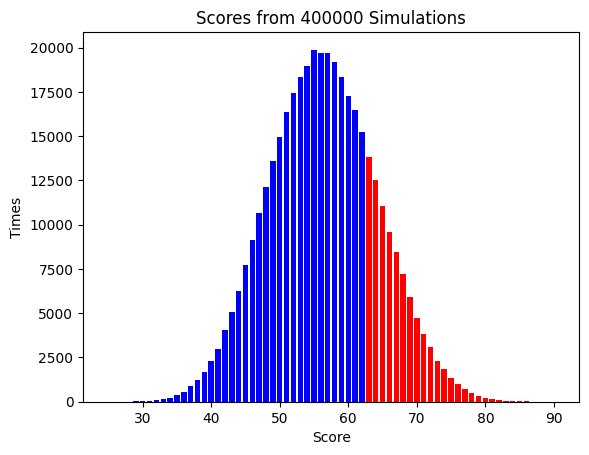

In [ ]:
# Benchmark from our programmed inference and decision

print(f"AVG score after {repeat} games : {round_one_score/repeat}")
print(f"Times player got yahtzee : {times_yahtzee}")
print(f"Times player got yahtzee and over 63 : {times_yahtzee_and_63}")
print("")

Ysum = 0
for key, value in games_score.items():
    if key >= 63:
        Ysum += value

print(f"Percentage of games :: Score over 63 : {round((Ysum/repeat),2)*100}%")
print(f"percentage of games :: yahtzee : {round((times_yahtzee/repeat),3)*100}%")
print(f"percentage of games :: yahtzee and score over 63 : {round((times_yahtzee_and_63/repeat),3)*100}%")
# Plotting the scores from games_score
colors = ['red' if score >= 63 else 'blue' for score in games_score.keys()]
plt.bar(games_score.keys(), games_score.values(), color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {repeat} Simulations')
plt.show()

### Scenario 2: Strategy with Three of a Kind

The thought behind this is that in order to get the **63-bonus of 50 points**, we want to get an **average of three dice on each kind**.

* We start out with an initial inference on the dice to get the probabilities of "three of a kind" and "probability of Yahtzee". 
* In our inference we also give a huge bonus for dice that is 3 or above, since they already are 3x
* However, we penalize the number 1 because in the end it doesn't really contribute all that much to the final score.
* For example if we roll 1,1,1,6,6 : then 6,6 is higher rated

Then we do a `KeepDiceDecision()` which gives us the number of different dice we should keep. It does this by doing an inference on the different probabilities when keeping multiple dice `keepMultipleInference()`. We do this until we reach our final decision, `endTurnDecision()`, where we do a greedy inference if we didn't get a clear decision. Also, if we decided to keep 4, 5, or 6 but we didn't have three of them, we can set our 1-spot to zero instead of wasting our "good spots" on a bad score. This can only be done once.


### Scenario 4: Probability Distribution and Utility Calculation
This implementation calculates the probability distribution for each of the dice sides, multiplies the probabilities by their corresponding dice values, and sums them up to get the dice utility. The algorithm then selects the option that provides the highest utility.
- The function cumulative_probability_distribution_for_dice_set calculates the probability distribution of getting 0 to N of any type of dice side, given the remaining number of turns and the number of dice rolled.
- The algorithm utilizes this by keeping the dice that yield the highest local utility and rerolling the ones that do not.
- In the final part of the algorithm, the section that gives the highest score is selected.
- The following example illustrates a simulation of the first turn in a game:
<br>
Dice values after first roll:       [5, 2, 5, 3, 6]
<br>
Number of dice for each side:       [0, 1, 1, 0, 2, 1]
<br>
Expected_utilities for each dice:   [2.11, 5.37, 8.06, 8.42, 16.31, 16.11]
<br>
Kept_dice: 5



In [ ]:


def binomial_probability(n, k, p):
    """Calculate binomial probability of getting exactly k successes in n trials"""
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

def cumulative_probability_distribution_for_dice_set(n_turns=3, rolled_dice=1, ):
    p = 1 / 6 
    
   
    current_distribution = [0] * (rolled_dice + 1)
    current_distribution[0] = 1.0  
    for turn in range(n_turns):
        next_distribution = [0] * (rolled_dice + 1)
        
        for current_ones in range(rolled_dice + 1):
            remaining_dice = rolled_dice - current_ones

            for new_ones in range(remaining_dice + 1):
                prob_new_ones = binomial_probability(remaining_dice, new_ones, p)
                next_distribution[current_ones + new_ones] += current_distribution[current_ones] * prob_new_ones
                
        current_distribution = next_distribution
    current_distribution = [round(prob, 4) for prob in current_distribution]

    return current_distribution

In [ ]:

import random
import pandas as pd
import math 

In [ ]:

class YahtzeeSection:
    def __init__(self, name, is_set, score, number):
        self.name = name
        self.is_set = is_set
        self.score = score
        self.number = number

class Game:
    def __init__(self):
        self.dice_set = [0, 0, 0, 0, 0]
        self.locked_dice = [False, False, False, False, False]
        self.sections = [
            YahtzeeSection("Ones", False, 0, 1),
            YahtzeeSection("Twos", False, 0, 2),
            YahtzeeSection("Threes", False, 0, 3),
            YahtzeeSection("Fours", False, 0, 4),
            YahtzeeSection("Fives", False, 0, 5),
            YahtzeeSection("Sixes", False, 0, 6),
        ]
        self.total_rounds = 6
        self.total_score = 0
        self.total_turns_in_a_round = 3 

    def roll_all_dice(self):
        for i in range(5):
            if self.locked_dice[i] == False:
                self.dice_set[i] = random.randint(1, 6)


    def calculate_score(self):
        for section in self.sections:
            self.total_score += section.score

    def make_decision_greedy(self, expected_utilities, turn):
        for section in self.sections:
            if section.is_set == True:
                expected_utilities[section.number - 1] = 0
        
        max_utility = max(expected_utilities)
        max_utility_index = expected_utilities.index(max_utility)
        
        return max_utility_index
       
     


    def play_round(self):
        remaining_turns = self.total_turns_in_a_round 
        for turn in range(self.total_turns_in_a_round):
            remaining_turns = remaining_turns - turn
            
            self.roll_all_dice()
            
          
            dice_count = []
            expected_utilities = []

            for dice_value in range(6):
                dice_count.append(self.dice_set.count(dice_value + 1))

                simulated_rolled_dice = 5 - dice_count[dice_value]
                distribution = cumulative_probability_distribution_for_dice_set(n_turns=self.total_turns_in_a_round - turn, rolled_dice=simulated_rolled_dice)
                

                expected_utility = 0
                for k, prob in enumerate(distribution):
                    expected_utility += (k + dice_count[dice_value]) * prob * (dice_value + 1)

                
                expected_utilities.append(expected_utility)
            
            kept_dice = self.make_decision_greedy(expected_utilities, turn) + 1
            
            
            
            for i in range(len(self.dice_set)):
                if self.dice_set[i] == kept_dice:
                    self.locked_dice[i] = True
                else:
                    self.locked_dice[i] = False
 

        products = []
        for i in range (6):
          
            prod = dice_count[i] * (i + 1)
            if self.sections[i].is_set == True:
                prod = 0
            products.append(prod) 


         

        maximum = max(products)
        maximum_index = products.index(maximum)
        self.sections[maximum_index].is_set = True
        self.sections[maximum_index].score = maximum
     


    def play_game(self):
        for i in range(self.total_rounds):
            self.play_round()
        self.calculate_score()
   

            

In [ ]:
# Simulation
num_simulations = 400000
total_scores = []
num_yahztees = 0
for _ in range(num_simulations):
    game = Game()
    game.play_game()
    total_scores.append(game.total_score)
    for section in game.sections:
        if section.score/5 == 1:
            num_yahztees += 1

# Analyze results
average_score = sum(total_scores) / num_simulations
print(f"Average score over {num_simulations} games: {average_score}")

for section in game.sections:
    print(f"{section.name}: {section.score}")


Average score over 40000 games: 49.420475
Ones: 2
Twos: 10
Threes: 3
Fours: 12
Fives: 10
Sixes: 12


In [ ]:
print(f"Percentage of games with Yahtzee: {num_yahztees / num_simulations * 100}%")
print(f"Num yahtzee {num_yahztees}")

Percentage of games with Yahtzee: 15.465000000000002%
Num yahtzee 6186


Average score over 40000 games: 49.420475


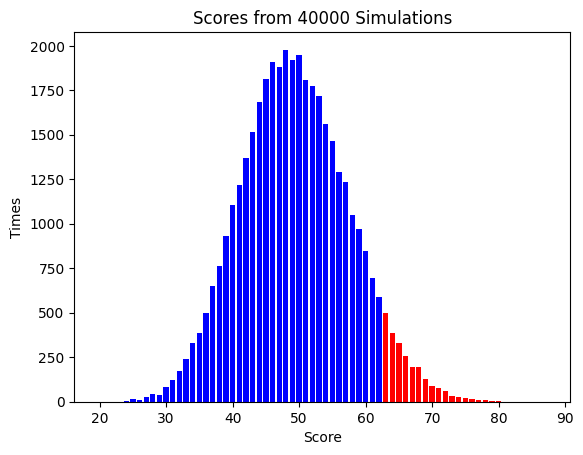

Percentage of games :: Score over 63 : 6.0%
percentage of games :: yahtzee : 15.5%


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter



average_score = sum(total_scores) / num_simulations
print(f"Average score over {num_simulations} games: {average_score}")


score_counts = Counter(total_scores)
larger_than_63 = [score for score in total_scores if score >= 63]
percentage_larger_than_63 = len(larger_than_63) / num_simulations * 100

scores = list(score_counts.keys())
frequencies = list(score_counts.values())
colors = ['red' if score >= 63 else 'blue' for score in scores]


plt.bar(scores, frequencies, color=colors)
plt.xlabel('Score')
plt.ylabel('Times')
plt.title(f'Scores from {num_simulations} Simulations')
plt.show()

print(f"Percentage of games :: Score over 63 : {round( len((larger_than_63 ))/num_simulations ,2)*100}%")
print(f"percentage of games :: yahtzee : {round((num_yahztees/num_simulations),3)*100}%")




### Algorithm comparisons

In [ ]:
# Benchmark from our programmed inference and decision

print(f"AVG score Greedy:   {round_one_score/repeat}\nProbability Distribution and Utility: {average_score}")
print(f"Times player got yahtzee greedy: {times_yahtzee}\nTimes player got yahtzee Probability Distribution and Utility Calculation: {num_yahztees}")
print(f"Times player got over 63 points Greedy: {round((Ysum/repeat),2)*100}\nTimes player got over 63 points Probability Distribution and Utility Calculation: {percentage_larger_than_63}")

AVG score Greedy:   56.36431
Probability Distribution and Utility: 49.420475
Times player got yahtzee greedy: 69299
Times player got yahtzee Probability Distribution and Utility Calculation: 6186
Times player got over 63 points Greedy: 22.0
Times player got over 63 points Probability Distribution and Utility Calculation: 5.8549999999999995
